<a href="https://colab.research.google.com/github/3monochloride4/Bangkit-Capstone-Project-repo/blob/main/ML_model_minterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
!pip install tensorflowjs

In [5]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

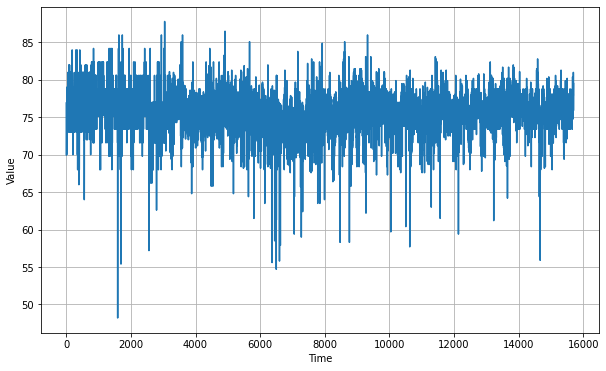

In [6]:
import csv
i=1
time_step = []
precipitation = []

with open('/tmp/datasetCuacaSmg1957-2021fix.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    precipitation.append(float(row[3]))
    time_step.append(i)
    i+=1

series = np.array(precipitation)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 13000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 80
batch_size = 200
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(13000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
65/65 [==============================] - 36s 34ms/step - loss: 49.8368 - mae: 50.3368
Epoch 2/100
65/65 [==============================] - 2s 34ms/step - loss: 24.4392 - mae: 24.9392
Epoch 3/100
65/65 [==============================] - 2s 34ms/step - loss: 5.1697 - mae: 5.6290
Epoch 4/100
65/65 [==============================] - 2s 33ms/step - loss: 3.9526 - mae: 4.3972
Epoch 5/100
65/65 [==============================] - 2s 34ms/step - loss: 3.8937 - mae: 4.3374
Epoch 6/100
65/65 [==============================] - 2s 34ms/step - loss: 3.8405 - mae: 4.2841
Epoch 7/100
65/65 [==============================] - 2s 34ms/step - loss: 3.7842 - mae: 4.2277
Epoch 8/100
65/65 [==============================] - 2s 34ms/step - loss: 3.7239 - mae: 4.1674
Epoch 9/100
65/65 [==============================] - 2s 34ms/step - loss: 3.6586 - mae: 4.1017
Epoch 10/100
65/65 [==============================] - 2s 33ms/step - loss: 3.5864 - mae: 4.0291
Epoch 11/100
65/65 [========================

(1e-08, 0.0001, 0.0, 20.0)

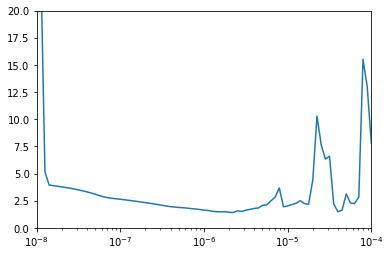

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 20])

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=80, batch_size=200, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", 'accuracy'])
history = model.fit(train_set,epochs=100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
65/65 [==============================] - 5s 33ms/step - loss: 10.4806 - mae: 10.9488 - accuracy: 0.0000e+00
Epoch 2/100
65/65 [==============================] - 2s 33ms/step - loss: 2.5637 - mae: 3.0024 - accuracy: 0.0000e+00
Epoch 3/100
65/65 [==============================] - 2s 34ms/step - loss: 2.2950 - mae: 2.7331 - accuracy: 0.0000e+00
Epoch 4/100
65/65 [==============================] - 2s 34ms/step - loss: 2.1481 - mae: 2.5859 - accuracy: 0.0000e+00
Epoch 5/100
65/65 [==============================] - 2s 34ms/step - loss: 2.0381 - mae: 2.4757 - accuracy: 0.0000e+00
Epoch 6/100
65/65 [==============================] - 2s 34ms/step - loss: 1.9355 - mae: 2.3726 - accuracy: 0.0000e+00
Epoch 7/100
65/65 [==============================] - 2s 34ms/step - loss: 1.8402 - mae: 2.2766 - accuracy: 0.0000e+00
Epoch 8/100
65/65 [==============================] - 2s 35ms/step - loss: 1.7536 - mae: 2.1901 - accuracy: 0.0000e+00
Epoch 9/100
65/65 [==============================] - 2

In [21]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], 60)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time-60:-1, -1, 0]
print(rnn_forecast.shape)

(15639, 60, 1)
(2698,)


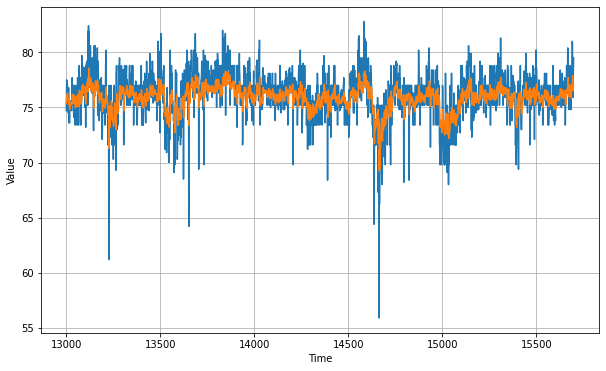

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.2396287

<Figure size 432x288 with 0 Axes>

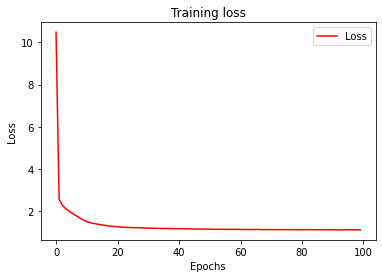

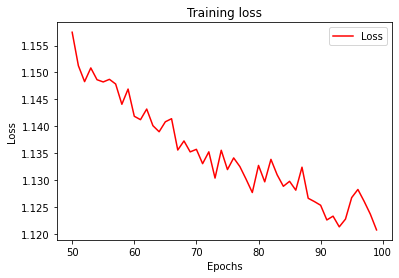

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[50:]
zoomed_epochs = range(50,100)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [25]:
print(rnn_forecast.shape, x_valid.shape)

(2698,) (2698,)


In [26]:
print(rnn_forecast)

[75.37376 75.3749  75.67906 ... 76.53773 76.94933 77.03516]


In [27]:
import time
saved_model_path = "/tmp/saved_model/{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [28]:
!tensorflowjs_converter --input_format=keras {saved_model_path} /tmp/converted_model_minterm

2021-06-07 13:35:24.555828: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
